In [1]:
import os
from typing import Tuple

from matplotlib.figure import Figure
from matplotlib.axes import Axes
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

from anomaly.constants import GALAXY_LINES

In [2]:
from typing import Tuple
from matplotlib.figure import Figure
from matplotlib.axes import Axes


def fig_axs_interpret_cluster(
    wave: np.array,
    mean_anomaly: np.array,
    median_anomaly: np.array,
    median_weights: np.array,
    mean_weights: np.array,
    fig_size=None,
) -> Tuple[Figure, Axes]:
    """
    Plot the mean and median anomaly and the mean and median
    explanation weights.

    INPUT

    wave: wavelength array
    mean_anomaly: mean anomaly array
    median_anomaly: median anomaly array
    median_weights: median explanation weights array
    mean_weights: mean explanation weights array
    fig_size: figure size

    OUTPUT

    fig: figure
    axs: axes
    """

    fig, axs = plt.subplots(
        nrows=3,
        ncols=1,
        figsize=fig_size,
        sharex=True,
        sharey=False,
        tight_layout=True,
    )

    axs[0].plot(wave, median_anomaly, c="black", label="Median")
    axs[0].set_ylabel("Normalized flux", fontsize=8)

    axs[1].plot(wave, mean_anomaly, c="black", label="Mean")
    axs[1].set_ylabel("Normalized flux", fontsize=8)

    axs[2].plot(wave, median_weights, color="black", label="Median")
    axs[2].plot(wave, mean_weights, color="blue", label="Mean")

    axs[2].set_ylabel("Explanation weight", fontsize=8)
    axs[2].set_ylim(0, 1.01)

    return fig, axs

In [3]:
# constants
lines = {
    "h-beta": 4861.352,
    "OIII_1": 4958.911,
    "OIII_2": 5006.843,
}

# region_name = "h_beta_OIII"
region_name = "OIII"

In [4]:
# directories for data
bin_id = "bin_03"
user = "/home/edgar"
work_directory = f"{user}/spectra/0_01_z_0_5_4_0_snr_inf"
model = "256_128_64/latent_12"
iml_use_case_directory = (
    f"{user}/explain-me-why/sections/" "figures/iml_use_cases"
)

# metric = "mse_filter_250kms_noRel97"
metric = "mse_noRel100"
# metric = "mse_filter_250kms_noRel100"
# metric = "mse_noRel97"
# metric = "mse_filter_250kms_rel100"
# metric = "mse_filter_250kms_rel97"
# metric = "mse_rel100"
# metric = "mse_rel97"
data_directory = f"{work_directory}/{bin_id}/explanation/{model}/{metric}"

In [5]:
wave = np.load(f"{work_directory}/wave_spectra_imputed.npy")
anomalies = np.load(f"{data_directory}/top_anomalies.npy")
df_anomalies = pd.read_csv(
    f"{data_directory}/top_anomalies.csv.gz", index_col="specobjid"
)

# load the weights
explanation_weights = np.load(
    f"{data_directory}/explanation_weights/weights_all_abs_"
    f"smooth_True_drop_0.05_{metric}_bin_03.npy"
)

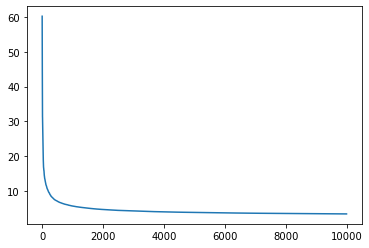

In [6]:
# sort scores in descending order in place in the df
df_anomalies.sort_values(by="score", ascending=False, inplace=True)
# reverse spectra in anomalies array as well
anomalies = anomalies[::-1]
plt.plot(df_anomalies["score"].to_numpy())

In [7]:
explanation_weights.min(), explanation_weights.max()

(0.0, 1.0)

## Clustering of weights for H $\alpha$ + [NII] doublet

In [8]:
# Define the regions of interest
radious = 20

# mask_region_of_interest = wave > lines["h-beta"] - radious
# mask_region_of_interest &= wave < lines["OIII_2"] + radious
mask_region_of_interest = wave > lines["OIII_1"] - radious
mask_region_of_interest &= wave < lines["OIII_2"] + radious

88

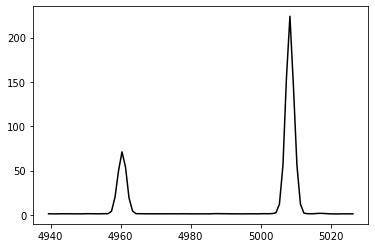

In [9]:
plt.plot(
    wave[mask_region_of_interest],
    anomalies[0][mask_region_of_interest],
    color="black",
)
mask_region_of_interest.sum()

In [10]:
# create array to store the weights of the h alpha NII region
region_weights = explanation_weights[:, mask_region_of_interest]
anomalies_region_of_interest = anomalies[:, mask_region_of_interest]
wave_region_of_interest = wave[mask_region_of_interest]
region_weights.shape, anomalies_region_of_interest.shape

((10000, 88), (10000, 88))

In [11]:
# Create a list to store the evaluation metric values
inertias = []
n_clusters = range(2, 12)
# Fit the k-means model with a range of values for the number of clusters
for n in n_clusters:
    kmeans = KMeans(n_clusters=n, random_state=0)
    kmeans.fit(region_weights)
    inertias.append(kmeans.inertia_)
    print(f"n: {n}, inertia: {kmeans.inertia_}", end="\r")

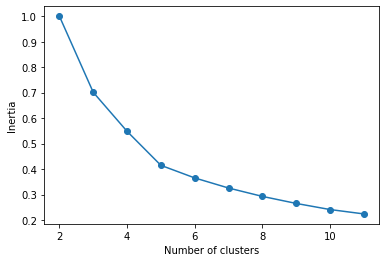

In [12]:
# Plot the evaluation metric values against the number of clusters
fig, ax = plt.subplots(figsize=None)

inertias = np.array(inertias)
inertias = inertias / inertias.max()
ax.plot(n_clusters, inertias, "-o")
ax.set_xlabel("Number of clusters")
ax.set_ylabel("Inertia")

save_to = f"{user}/explain-me-why/sections/figures/iml_use_cases"

fig.savefig(f"{save_to}/kmeans_inertias_region_{region_name}_{metric}.pdf")

In [13]:
# Use k-means clustering to group the spectra
kmeans = KMeans(n_clusters=6, random_state=0)
cluster_labels = kmeans.fit_predict(region_weights)

Cluster N 0: 1054
Cluster N 1: 5822
Cluster N 2: 257
Cluster N 3: 180
Cluster N 4: 1461
Cluster N 5: 1226


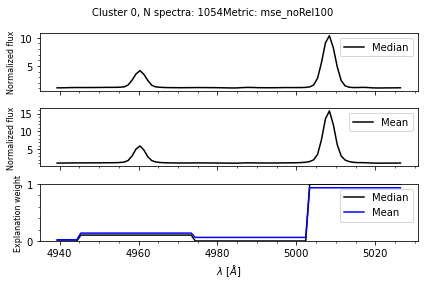

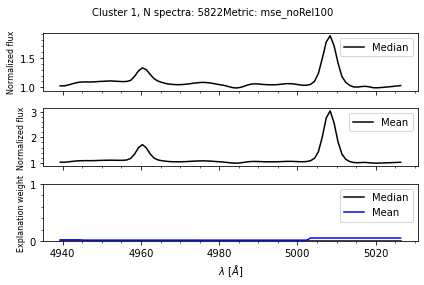

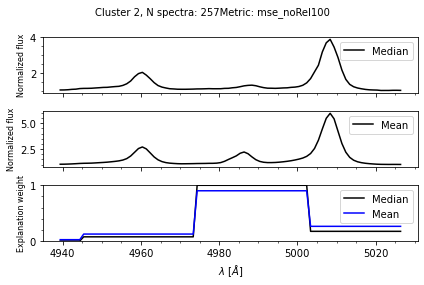

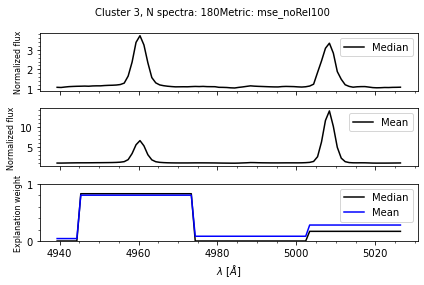

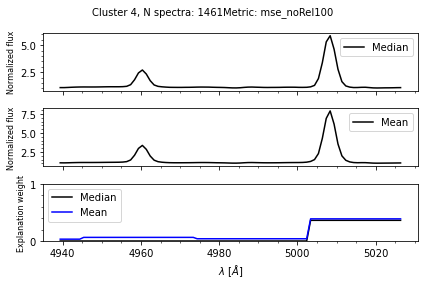

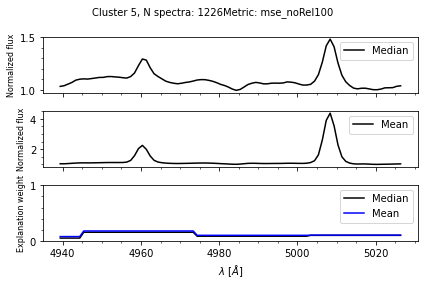

In [14]:
# plot mean and median of the anomalies and explanation weights
# per cluster
n_clusters = kmeans.n_clusters

for cluster_number in range(n_clusters):

    # Select the spectra in the cluster
    cluster_anomalies = anomalies_region_of_interest[
        cluster_labels == cluster_number
    ]

    n_spectra_in_cluster = len(cluster_anomalies)

    cluster_weights = region_weights[cluster_labels == cluster_number]
    cluster_mean_anomaly = np.mean(cluster_anomalies, axis=0)
    cluster_median_anomaly = np.median(cluster_anomalies, axis=0)

    # Compute summary statistics for the explanations in the cluster
    cluster_median_weights = np.median(cluster_weights, axis=0)
    cluster_mean_weights = np.mean(cluster_weights, axis=0)
    cluster_std_weights = np.std(cluster_weights, axis=0)

    fig, axs = fig_axs_interpret_cluster(
        wave=wave_region_of_interest,
        mean_anomaly=cluster_mean_anomaly,
        median_anomaly=cluster_median_anomaly,
        median_weights=cluster_median_weights,
        mean_weights=cluster_mean_weights,
        fig_size=None,
    )

    axs[2].set_xlabel("$\lambda$ [$\AA$]")

    for ax in axs:
        ax.legend()
        ax.minorticks_on()

    fig.suptitle(
        (
            f"Cluster {cluster_number}, "
            f"N spectra: {n_spectra_in_cluster}"
            f"Metric: {metric}"
        ),
        fontsize=10,
    )

    print(f"Cluster N {cluster_number}: " f"{n_spectra_in_cluster}")

    # create cluster directory if it does not exist
    cluster_directory = f"{iml_use_case_directory}/clustering/{region_name}"

    if not os.path.exists(cluster_directory):
        os.makedirs(cluster_directory)

    fig.savefig(
        f"{cluster_directory}/region_{region_name}_"
        f"cluster_{cluster_number}_metric_{metric}_bin_{bin_id}.pdf"
    )